<a href="https://colab.research.google.com/github/srija29/Employee-Project/blob/main/srijakot_RL_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install gymnasium matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00


In [23]:
from google.colab import drive
drive.mount('/content/drive')
%cd ..
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive


In [3]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import optuna

In [61]:
# PART 1
# 1.1 Deterministic Environment

class GridEnvironment(gym.Env):

    def __init__(self):

      self.observation_space = spaces.Discrete(16)
      self.action_space = spaces.Discrete(4)
      self.max_timesteps = 15
      self.grid_size = 4
      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [3, 3]
      self.rescue = np.asarray([[2, 0], [0, 3],[1,1]])
      self.danger = np.asarray([[1, 2], [0,1], [3, 1]])

      self.state = np.zeros((4,4))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      self.states = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
      self.actions = [0,1,2,3]
      self.terminated = False

    def reset(self, **kwargs):
      self.max_timesteps = 15
      self.grid_size = 4
      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [3, 3]
      self.rescue = np.asarray([[2, 0], [0, 3],[1,1]])
      self.danger = np.asarray([[1, 2], [0,1], [3, 1]])

      self.state = np.zeros((4,4))
      self.actions = [0,1,2,3]

      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.8
      self.state[tuple(self.rescue[0])] = 0.7
      self.state[tuple(self.rescue[1])] = 0.7
      self.state[tuple(self.rescue[2])] = 0.7
      self.state[tuple(self.danger[0])] = 0.3
      self.state[tuple(self.danger[1])] = 0.3
      self.state[tuple(self.danger[2])] = 0.3


      observation = self.state.flatten()

      self.terminated = False
      self.rescue_flag1 = True
      self.rescue_flag2 = True
      self.rescue_flag3 = True

      return observation

    def step(self, action):
      if action not in self.actions:
            raise ValueError("Invalid action")

      truncated = False
      self.state = np.random.choice(self.observation_space.n)

      if action == 0 and self.agent_pos[0] < self.grid_size - 1: #right
        self.agent_pos[0] += 1
      elif action == 1 and self.agent_pos[0] > 0: #left
        self.agent_pos[0] -= 1
      elif action == 2 and self.agent_pos[1]  < self.grid_size - 1: #up
        self.agent_pos[1] += 1
      elif action == 3 and self.agent_pos[1] > 0: #down
        self.agent_pos[1] -= 1
      else:
        truncated = True

      self.state = np.zeros((4,4))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.8
      self.state[tuple(self.rescue[0])] = 0.7
      self.state[tuple(self.rescue[1])] = 0.7
      self.state[tuple(self.rescue[2])] = 0.7
      self.state[tuple(self.danger[0])] = 0.3
      self.state[tuple(self.danger[1])] = 0.3
      self.state[tuple(self.danger[2])] = 0.3

      observation = self.state.flatten()
      terminated = False

      reward = 0
      if truncated:
        reward -= 20

      elif (self.agent_pos == self.goal_pos):
          reward = 20
          self.terminated = True

      elif np.array_equal(self.agent_pos, self.danger[0]):
          reward = -5

      elif np.array_equal(self.agent_pos, self.danger[1]):
          reward = -6

      elif np.array_equal(self.agent_pos, self.danger[2]):
          reward = -7

      elif self.rescue_flag1 and np.array_equal(self.agent_pos, self.rescue[0]):
          reward = 4
          self.rescue_flag1 = False

      elif self.rescue_flag2 and np.array_equal(self.agent_pos, self.rescue[1]):
          reward = 5
          self.rescue_flag2 = False

      elif self.rescue_flag3 and np.array_equal(self.agent_pos, self.rescue[2]):
          reward = 6
          self.rescue_flag3 = False


      return self.agent_pos, reward, truncated, self.terminated

    def render(self, mode='human', plot=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)

        def plot_image(plot_pos):
            # Initially setting every object to not be plotted.
            plot_agent, plot_victim, plot_danger, plot_goal = \
                False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.rescue[i], plot_pos) for i in range(len(self.rescue))):
                plot_victim = True
            if any(np.array_equal(self.danger[i], plot_pos) for i in range(len(self.danger))):
                plot_danger = True
            if np.array_equal(plot_pos, self.goal_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in [plot_victim, plot_danger, plot_goal ]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/agent.jpg'), zoom=0.25),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)
            #plot for victim
            elif plot_victim and \
                    all(not item for item in [plot_agent, plot_danger, plot_goal ]):
                victim = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/victim.jpg'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(victim)

            # Plot for Danger.
            elif plot_danger and \
                    all(not item for item in [plot_agent, plot_victim, plot_goal, ] ):
                danger = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/danger.jpg'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(danger)

            # Plot for Goal.
            elif plot_goal and \
                    all(not item for item in [plot_agent, plot_victim, plot_danger ]):
                goal = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/goal.jpg'), zoom=0.3),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)

            # plot for agent and rescue
            elif all(item for item in [plot_agent, plot_victim]) and \
                    all(not item for item in
                        [plot_danger, plot_goal]):
                agent_rescue = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/agentRescue.jpg'), zoom=0.1),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_rescue)
            #plot for agent and danger
            elif all(item for item in [plot_agent, plot_danger]) and \
                    all(not item for item in
                        [plot_victim, plot_goal]):
                agent_danger = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/agentDanger.jpg'), zoom=0.1),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_danger)
            #plot for agent and target
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_victim, plot_danger]):
                agent_goal = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/agentGoal.webp'), zoom=0.1),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_goal)

        coordinates_state_mapping_2 = {}
        for j in range(self.observation_space.n):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % int(np.sqrt(self.observation_space.n)), int(np.floor(j / np.sqrt(self.observation_space.n)))])
        print('coordinates_state_mapping_2', coordinates_state_mapping_2)
        plt.grid()
        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3])
        plt.yticks([0, 1, 2, 3])

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image


coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


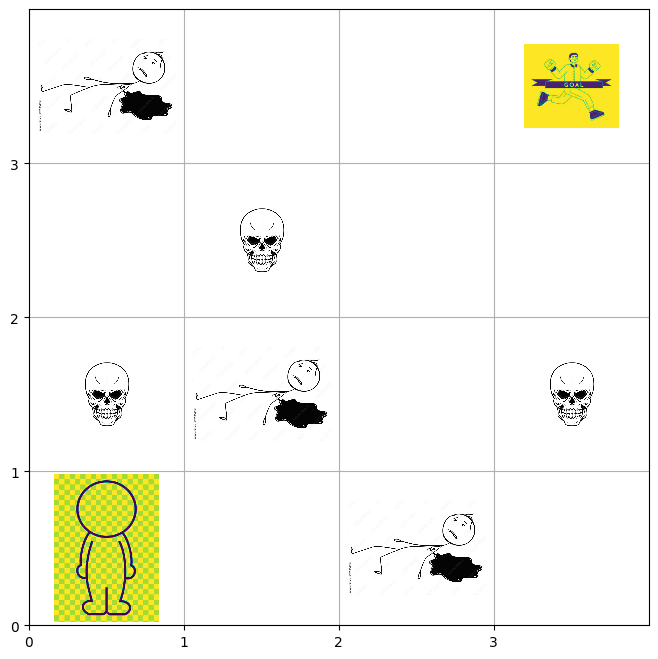

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [62]:
env = GridEnvironment()
obs = env.reset()

env.render()

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


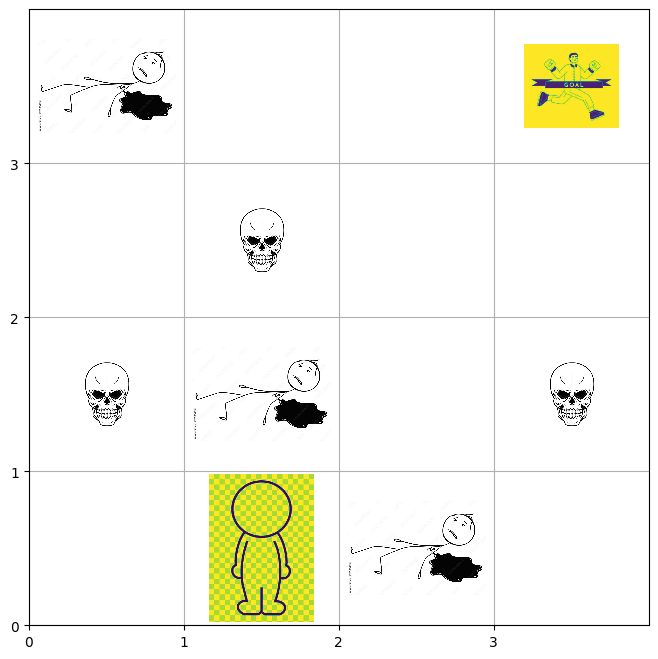

Current state: [1, 0] Action: 0 Reward: 0 Truncated: False Terminated: False


In [63]:
action = 0
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


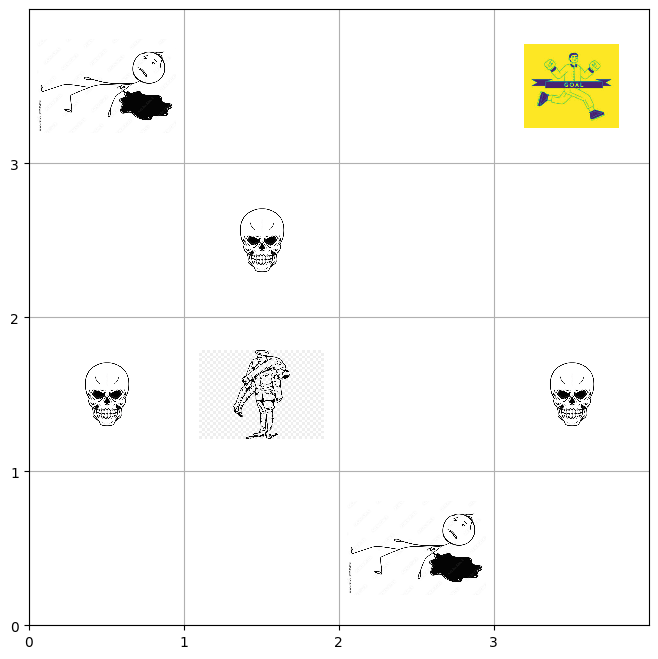

Current state: [1, 1] Action: 2 Reward: 6 Truncated: False Terminated: False


In [64]:
action = 2
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


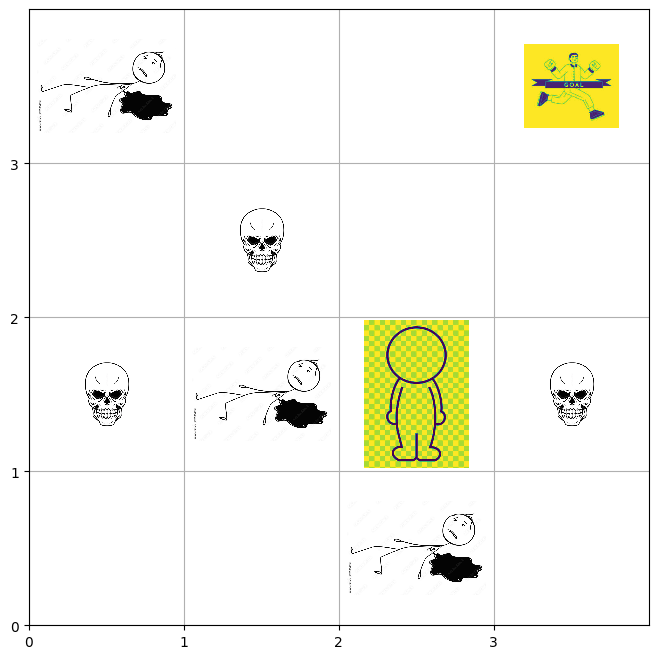

Current state: [2, 1] Action: 0 Reward: 0 Truncated: False Terminated: False


In [65]:
action = 0
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


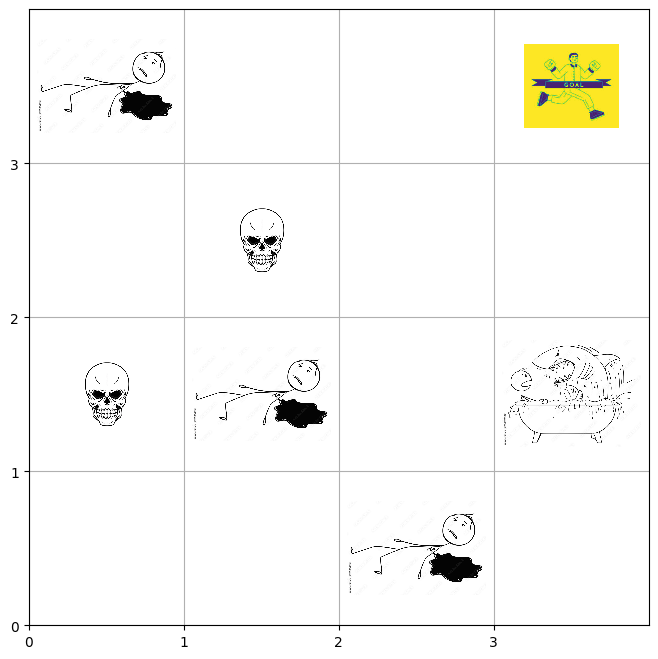

Current state: [3, 1] Action: 0 Reward: -7 Truncated: False Terminated: False


In [66]:
action = 0
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


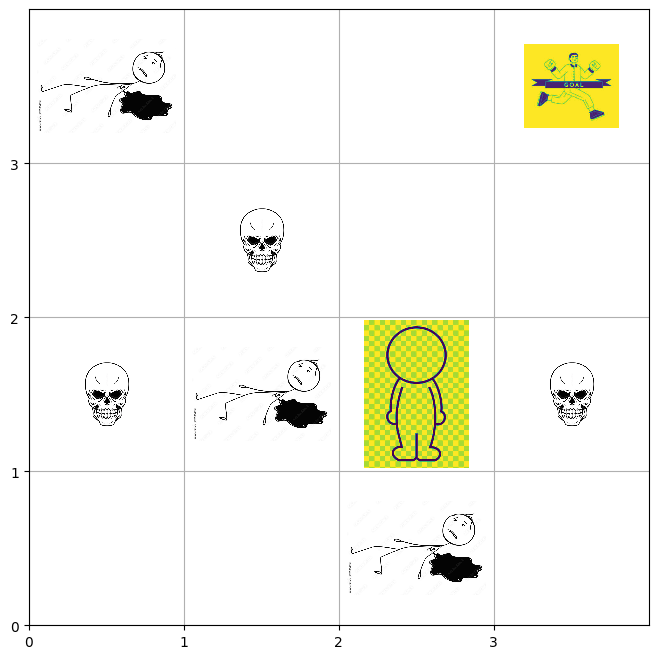

Current state: [2, 1] Action: 1 Reward: 0 Truncated: False Terminated: False


In [67]:
action = 1
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


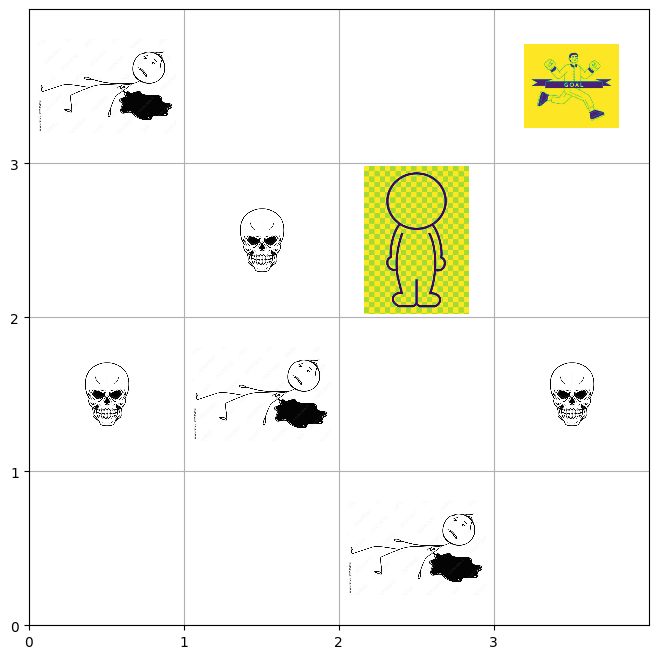

Current state: [2, 2] Action: 2 Reward: 0 Truncated: False Terminated: False


In [68]:
action = 2
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


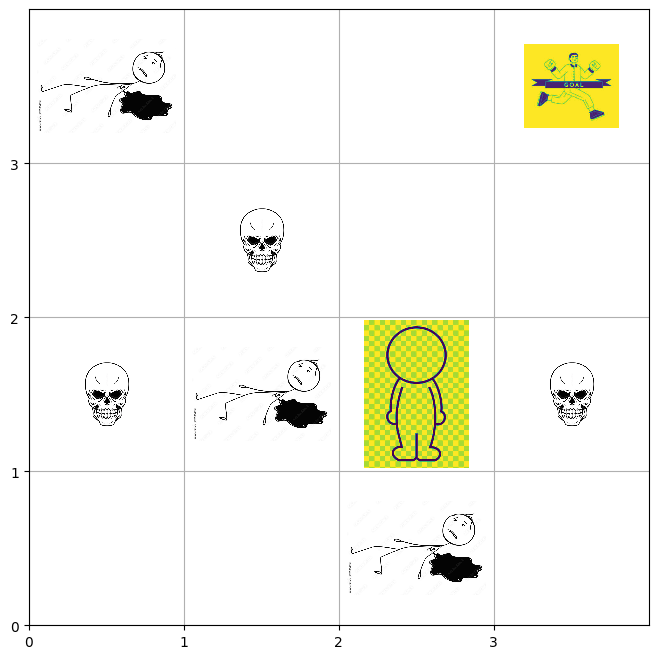

Current state: [2, 1] Action: 3 Reward: 0 Truncated: False Terminated: False


In [69]:
action = 3
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


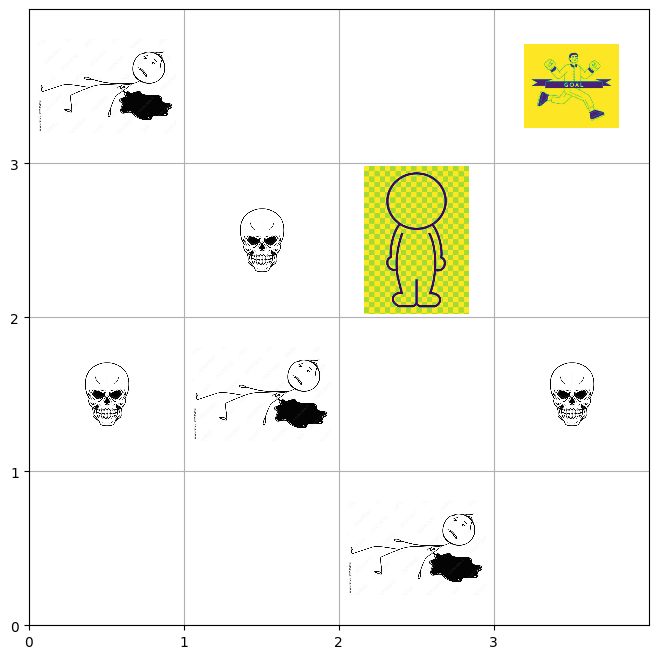

Current state: [2, 2] Action: 2 Reward: 0 Truncated: False Terminated: False


In [70]:
action = 2
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


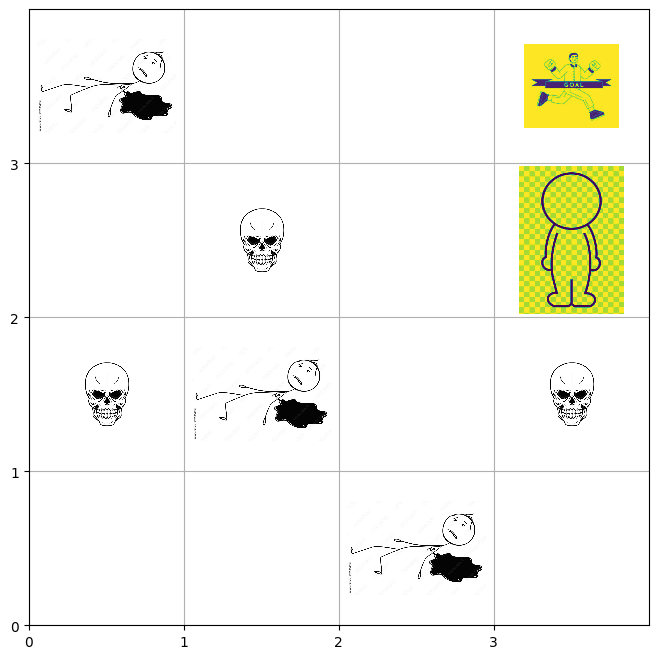

Current state: [3, 2] Action: 0 Reward: 0 Truncated: False Terminated: False


In [71]:
action = 0
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

coordinates_state_mapping_2 {0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 0]), 4: array([0, 1]), 5: array([1, 1]), 6: array([2, 1]), 7: array([3, 1]), 8: array([0, 2]), 9: array([1, 2]), 10: array([2, 2]), 11: array([3, 2]), 12: array([0, 3]), 13: array([1, 3]), 14: array([2, 3]), 15: array([3, 3])}


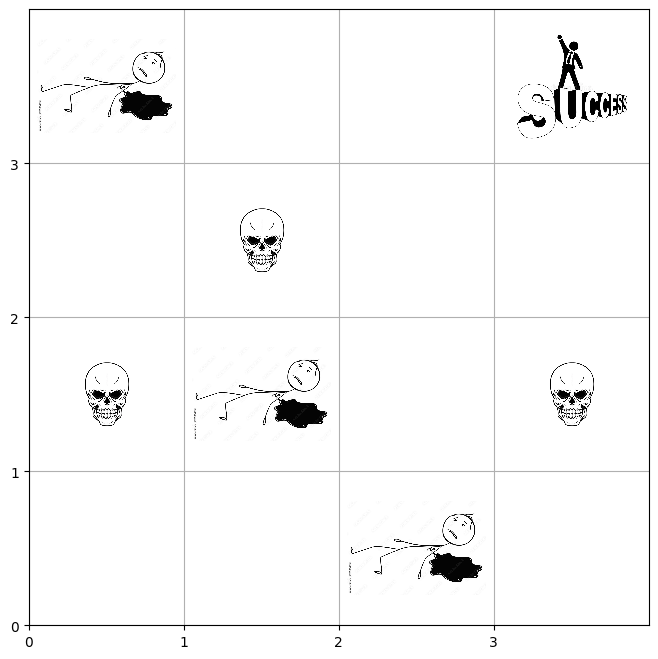

Current state: [3, 3] Action: 2 Reward: 20 Truncated: True Terminated: False


In [72]:
action = 2
observation, reward, terminated, truncated = env.step(action)
env.render(plot=True)
print("Current state:", observation, "Action:", action, "Reward:", reward, "Truncated:",truncated, "Terminated:", terminated)

In [72]:
env = GridEnvironment()
obs = env.reset()

env.render()